Install tensorflow imageio tensorflow-docs

In [1]:
# pip install tensorflow imageio tensorflow-docs

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display
import tensorflow_docs.vis.embed as embed


Loading the MNIST Handwritten digits dataset

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
BUFFER_SIZE / BATCH_SIZE  

234.375

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


Generator


In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

C:\Users\ferna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


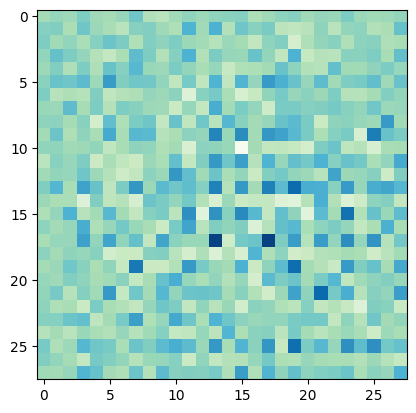

In [10]:
# using the untrained generator to generate an image from random noise
generator = make_generator_model()

noise = tf.random.normal([1,100])

generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap='GnBu_r')

Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [12]:
# using the untrained discriminator to predict whether an image is real or fake
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[0.00034994]], shape=(1, 1), dtype=float32)


C:\Users\ferna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss and Optimizer

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

Discriminator Loss

In [14]:
# Determine how well the discriminator was able to distinguish betweena  real and fake image
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator Loss

In [15]:
# determine if the generator is well enough to trick the disciminator 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

train the models

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Saving the checkpoints

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [18]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 15

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Generate and save images

In [19]:
def generate_and_save_images(model, epoch, test_input):
    predict = model(test_input, training = False)

    fig = plt.figure(figsize = (6,6))

    for i in range(predict.shape[0]):
        plt.subplot(3, 5, i+1)
        plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='GnBu_r')
        plt.axis('off')

    plt.savefig("image_frame/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

Training Function

In [20]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the image as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)


        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

Training the model

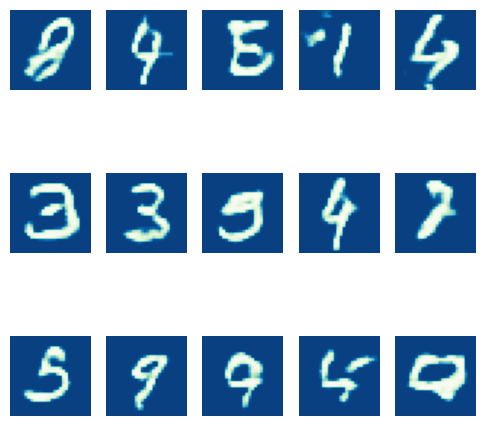

In [22]:
train(train_dataset, EPOCHS)



In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


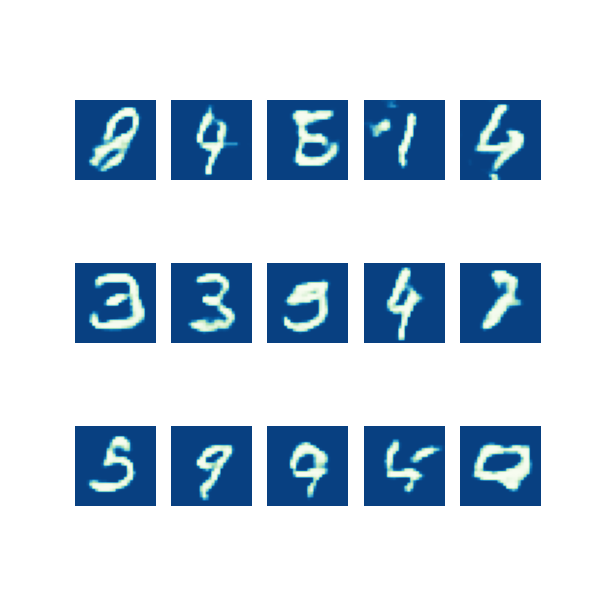

In [28]:
# Display a single image using the epoch number

def display_image(epoch_no):
    return PIL.Image.open('image_frame/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

Use imageio to create an animated gif using the images saved durign training

In [30]:
animated_file = 'dcgan.gif'

with imageio.get_writer(animated_file, mode = "I") as writer:
    filenames = glob.glob("image_frame/image*.png")
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)
    

C:\Users\ferna\AppData\Local\Temp\ipykernel_48404\1615378541.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\ferna\AppData\Local\Temp\ipykernel_48404\1615378541.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



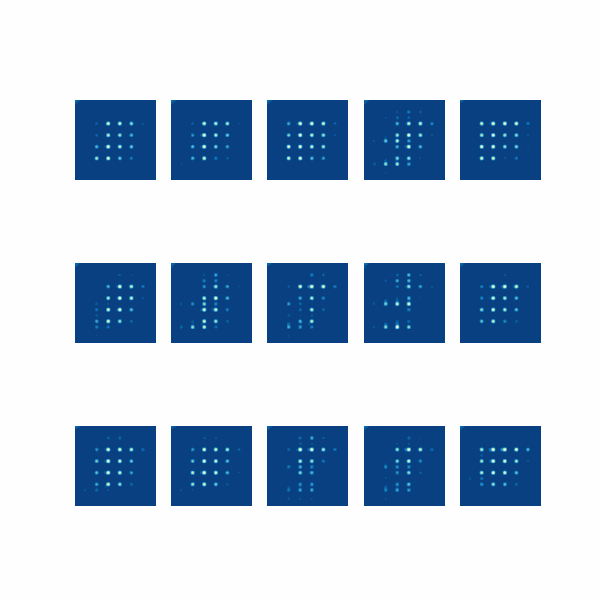

In [31]:
embed.embed_file(animated_file)